In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn import metrics

import torch
from torchtext import data, datasets
from torchtext.vocab import Vectors
from torch.nn import init
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [2]:
from model_CapsNet import *

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

In [3]:
def tokenizer(text): # create a tokenizer function
    """
    定义分词操作
    """
    return list(text)
LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)
original_train, original_val, original_test = data.TabularDataset.splits(
        path='2021MDPI_CapsNet/data/', train='train.csv', validation='train.csv',test='test.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
TEXT.build_vocab(original_train, original_val, original_test)

In [4]:
model = CapsuleNet()
"""
将前面生成的词向量矩阵拷贝到模型的embedding层
这样就自动的可以将输入的word index转为词向量
"""
# 训练
model.to(DEVICE)
# 训练
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [5]:
n_class = 2

In [6]:
model.load_state_dict(torch.load('2021MDPI_CapsNet/model/params.pkl'))#, map_location='cpu'))
model.eval()

CapsuleNet(
  (embedding): Embedding(22, 20)
  (lstm): LSTM(20, 40, batch_first=True)
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv3): Conv2d(1, 256, kernel_size=(8, 8), stride=(1, 1))
  (cbamBlock): CBAMBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (channel_excitation): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
    )
    (sigmoid): Sigmoid()
    (spatial_excitation): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
  )
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
  (capsule): Capsule()
)

# HPP

In [7]:
df_hpp = pd.read_csv('data/HPP.csv')[['peptide', 'Class']]

pe1 = df_hpp.loc[df_hpp['Class']=='PE1'].rename({'peptide':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)
dmp = df_hpp.loc[df_hpp['Class']=='Detected_MPs'].rename({'peptide':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)
mp = df_hpp.loc[df_hpp['Class']=='MPs'].rename({'peptide':'Seqs', 'Class':'Label'}, axis=1).reset_index(drop=True)

pe1['Label']=1
dmp['Label']=1
mp['Label']=0

pe1.to_csv('2021MDPI_CapsNet/pe1.csv', index=False)
dmp.to_csv('2021MDPI_CapsNet/dmp.csv', index=False)
mp.to_csv('2021MDPI_CapsNet/mp.csv', index=False)

In [8]:
train1,val1,test1 = data.TabularDataset.splits(
        path='2021MDPI_CapsNet/', train='pe1.csv',validation='pe1.csv',test='pe1.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter1 = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

train2,val2,test2 = data.TabularDataset.splits(
        path='2021MDPI_CapsNet/', train='dmp.csv',validation='dmp.csv',test='dmp.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train2,val2,test2)
test_iter2 = data.BucketIterator(val2, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

train3,val3,test3 = data.TabularDataset.splits(
        path='2021MDPI_CapsNet/', train='mp.csv',validation='mp.csv',test='mp.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train3, val3,test3)
test_iter3 = data.BucketIterator(val3, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

In [9]:
all_pred1 = []
all_true1 = []
all_p1 = []
for batch_idx, batch in enumerate(test_iter1):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        try:
            out = model(data)
        except:
            print(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        out1 = out[:,1]
        _,y_pre = torch.max(out,-1)
        
        all_p1.extend(list(out1.cpu().detach().numpy()))
        all_pred1.extend(list(y_pre.cpu().detach().numpy()))
        all_true1.extend(list(batch.Label.cpu().detach().numpy()))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [10]:
all_pred2 = []
all_true2 = []
all_p2 = []
for batch_idx, batch in enumerate(test_iter2):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        out1 = out[:,1]
        _,y_pre = torch.max(out,-1)
        
        all_p2.extend(list(out1.cpu().detach().numpy()))
        all_pred2.extend(list(y_pre.cpu().detach().numpy()))
        all_true2.extend(list(batch.Label.cpu().detach().numpy()))

In [11]:
all_pred3 = []
all_true3 = []
all_p3 = []
for batch_idx, batch in enumerate(test_iter3):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        out1 = out[:,1]
        _,y_pre = torch.max(out,-1)
        
        all_p3.extend(list(out1.cpu().detach().numpy()))
        all_pred3.extend(list(y_pre.cpu().detach().numpy()))
        all_true3.extend(list(batch.Label.cpu().detach().numpy()))

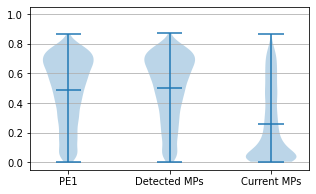

In [12]:
plt.figure(figsize=(5,3))
a = plt.violinplot([list(map(lambda x: 1-x, all_p1)), 
                    list(map(lambda x: 1-x, all_p2)), 
                    list(map(lambda x: 1-x, all_p3))],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(3)], ['PE1', 'Detected MPs', 'Current MPs'])
plt.ylim(-0.05, 1.05)
b = plt.grid(axis='y')
plt.show()

# massIVE-KB

In [21]:
from torchtext import data, datasets

test = pd.read_csv('2021MDPI_CapsNet/test.csv')

In [22]:
LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)
train, val, test = data.TabularDataset.splits(
                                path='2021MDPI_CapsNet/', 
                                train='train.csv',
                                validation='val.csv',
                                test='test.csv',
                                format='csv',
                                skip_header=True,
                                fields=[('Seqs', TEXT), ('Label', LABEL)])
TEXT.build_vocab(train, val, test)
n_class = 2

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

In [23]:
model_retrained = CapsuleNet()
model_retrained.to(DEVICE)
optimizer = optim.Adam(model_retrained.parameters(),lr=0.001)
model_retrained.load_state_dict(torch.load('log/CapsNet.pkl'))
model_retrained.eval()

CapsuleNet(
  (embedding): Embedding(22, 20)
  (lstm): LSTM(20, 40, batch_first=True)
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv3): Conv2d(1, 256, kernel_size=(8, 8), stride=(1, 1))
  (cbamBlock): CBAMBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (channel_excitation): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
    )
    (sigmoid): Sigmoid()
    (spatial_excitation): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
  )
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
  (capsule): Capsule()
)

In [24]:
test_iter = data.BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=False,device=DEVICE)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [25]:
all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model_retrained(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


TEST Accuracy : 0.826775217493534
TEST AUC : 0.9066519394863761
              precision    recall  f1-score   support

           0     0.8189    0.8449    0.8317     86178
           1     0.8354    0.8082    0.8216     83942

    accuracy                         0.8268    170120
   macro avg     0.8271    0.8265    0.8266    170120
weighted avg     0.8270    0.8268    0.8267    170120



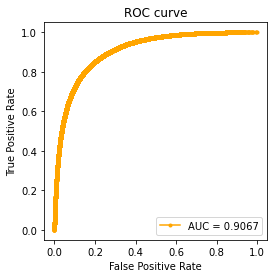

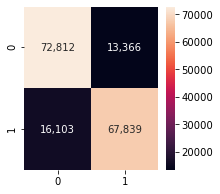

In [23]:
auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [24]:
np.save('log/result_CapsNet_fpr.npy', fpr)
np.save('log/result_CapsNet_tpr.npy', tpr)

# Case of cleavage sites count

In [26]:
probs = np.array(all_p1)
y_test = np.array(all_true1)
y_pred = np.array(all_pred1)

In [27]:
# index 다시 구해야함 ㅜㅜ.. 이터레이터로 
miss0_idx = np.load('data/CapsNet_miss0_idx.npy')
miss1_idx = np.load('data/CapsNet_miss1_idx.npy')
miss2_idx = np.load('data/CapsNet_miss2_idx.npy')

Test AUC : 0.8722738789879939
              precision    recall  f1-score   support

           0     0.7673    0.5865    0.6648     10839
           1     0.8958    0.9524    0.9232     40477

    accuracy                         0.8751     51316
   macro avg     0.8316    0.7694    0.7940     51316
weighted avg     0.8687    0.8751    0.8687     51316



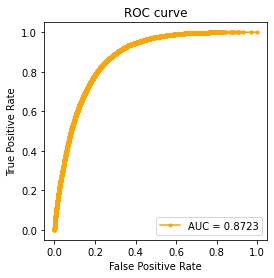

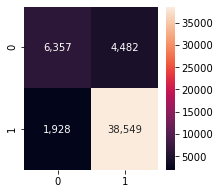

Test AUC : 0.849874249719154
              precision    recall  f1-score   support

           0     0.7535    0.7791    0.7661     31792
           1     0.7792    0.7535    0.7661     32882

    accuracy                         0.7661     64674
   macro avg     0.7663    0.7663    0.7661     64674
weighted avg     0.7665    0.7661    0.7661     64674



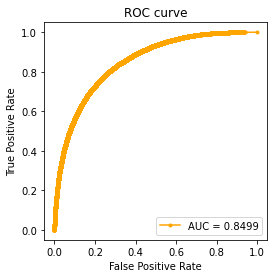

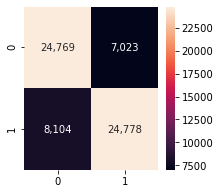

Test AUC : 0.8625834376223486
              precision    recall  f1-score   support

           0     0.8729    0.9573    0.9131     43547
           1     0.7080    0.4263    0.5322     10583

    accuracy                         0.8535     54130
   macro avg     0.7904    0.6918    0.7227     54130
weighted avg     0.8406    0.8535    0.8387     54130



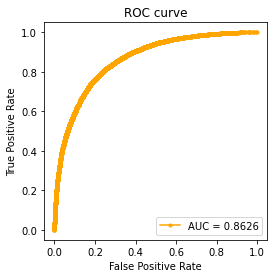

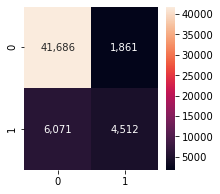

In [28]:
y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
y_test_miss0 = y_test[miss0_idx]
y_test_miss1 = y_test[miss1_idx]
y_test_miss2 = y_test[miss2_idx]

auc = roc_auc_score(y_test_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(y_test_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(y_test_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(y_test_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(y_test_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(y_test_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

